In [6]:
# Import libraries
#Group4 CA4
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from random import randint
import numpy as np

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


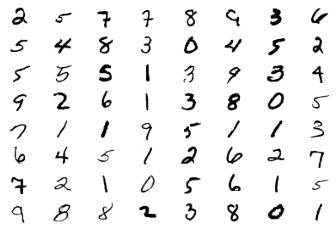

In [7]:
# Preparing the dataset
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Making a copy before flattening for the next code-segment which displays images
x_train_drawing = x_train

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) 
x_test = x_test.reshape(x_test.shape[0], image_size)

# Convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Show some random digits
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(x_train_drawing[randint(0, x_train.shape[0])], cmap='Greys')

print(x_train.shape) 
print(y_train.shape)  
print(x_test.shape)  
print(y_test.shape)

In [8]:
# Define cost functions

# Condition metric
def H(X, y, theta):
    out=np.asarray([ np.sum(np.maximum(0,1+(X[i]@theta) - (y[i])*(X[i]@theta))) for i in range(X.shape[0])])
    return out


# SVM loss function
def svm_loss_re(X, y, theta, lamda):
    h = H(X, y, theta)
    penalty = lamda*np.linalg.norm(theta,ord='fro')
    loss = np.mean(h)
    #print('loss=',loss)
    #print('penalty=',penalty)
    return penalty + loss 

# Gradient of SVM loss function
def svm_grad_re(X, y, theta, lamda): 
    grad=np.zeros((X.shape[1],num_classes))
    for i in range(X.shape[0]):
        s = np.where((X[i]@theta) - (y[i])*(X[i]@theta)>0,1,0)- y[i]*np.sum(np.where((X[i]@theta) - (y[i])*(X[i]@theta)>0,1,0))
        grad += np.tensordot(s,X[i],axes=0).T
    grad = grad/X.shape[0]
    
    grad = grad+2*lamda*theta
    return grad


In [9]:
#Split dataset to num_worker workers
def split_workers(X_data, y_data, num_worker):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    num_data = len(y_data)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y_data[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
        
    return data_X_list, data_y_list

# Function to train master-worker
def train(X_data, y, num_worker, num_iter, var, pLevel, lamda, alpha, lr_fade=1):
    
    # lamda: penalty
    # alpha: learning rate
    # var: noise variance
    # pLevel: noise adding probability
    # num_iter: number of iterations
    
    # Split into 10 subdatasets for 10 workers
    data_X_list, data_y_list = split_workers(X_data, y, num_worker)
    
    # train
    weight = np.random.rand(X_data.shape[1], 10)
    
    total_loss_list=[]
    accu=[]
    for i_iter in range(num_iter):
        gradient_list=[]
        # Fill in
        for j_worker in range(num_worker):
            # call data_j from worker j
            data_X_j=data_X_list[j_worker]
            data_y_j=data_y_list[j_worker]
            # get grad from worker j
            gradient_list.append(svm_grad_re(data_X_j, data_y_j, weight, lamda))
            # add noise
            
        # Fill in        
        grad_ave = 1./num_worker*sum(gradient_list)
        alpha *= lr_fade
        weight -= alpha * grad_ave
        loss=svm_loss_re(X_data, y, weight, lamda)
        print(loss)
        total_loss_list.append(loss)
        
    return total_loss_list


In [10]:
loss = train(x_train, y_train, num_worker=10, num_iter=30, var=0, pLevel=0, lamda=0.1, alpha=0.01, lr_fade=0.999)

111239.7050648644
106466.93071092955
102667.8338130228
101695.01793341956
101817.99860998197
102501.81418902436
103293.20030989018
104051.3748265792
104799.6943729234
105581.53206006682
106474.34642113473
107507.65676144148
108639.39993531036
109846.0299509578
111102.15053205928
112379.6301495881
113671.79028923524
114965.32483454554
116257.75839324637
117545.48240711959
118825.23969175505
120097.351243703
121362.44460724483
122618.46415079568
123866.52204378086
125103.07187968506
126328.94717269737
127547.31755255625
128755.76059094782
129948.15811495336


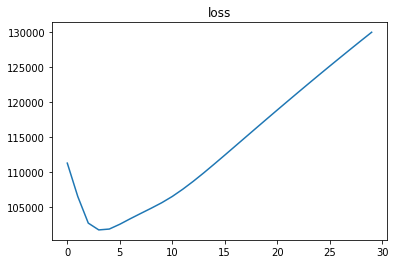

In [11]:
plt.plot(np.arange(30),loss)
plt.title('loss')
plt.show()

We can select the master node as the most critical node in the star topology framework (Algo 1) but other workers could be selected too by adjusting their weights.

In the 2 star topology network, nodes 5 and 6 are the most crucial to protect since it is these nodes which initialize the 2 respective stars